# Object Detection Study

Compare and benchmark our generated results with the ground truths using object detection, to help determine whether or not any distortions or misrepresentation of object features occur due to our colorization.

In [1]:
# import libraries
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)
    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(image_array)

    return preprocessed_image

def data_generator(dataPath):
    return ImageDataGenerator().flow_from_directory(
        dataPath, 
        target_size=(224, 224), 
        batch_size=32, 
        class_mode='categorical',
        shuffle=False)

# define model architecture
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

In [4]:
# verify model output
image = Image.open('../Datasets/mini_imagenet/imagenet-mini/train/n01440764/n01440764_4965.JPEG')
preprocessed_image = preprocess_image(image)
predictions = model.predict(preprocessed_image)

top_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=5)[0]
for prediction in top_predictions:
    print(prediction[1], prediction[2])

tench 0.3723456
coho 0.19863468
barracouta 0.1533031
assault_rifle 0.08119961
sturgeon 0.07733496


### Obtain Classification Scores for both models

We will now run the ResNet50 model for both the ground truth, as well as coloured images, and obtain the prediction scores for each

In [14]:
# Run model for both cases

gt_data = data_generator('../Datasets/mini_imagenet/imagenet-mini/test_images_gt')
pred_data = data_generator('../Datasets/mini_imagenet/imagenet-mini/test_images_pred')

gt_predictions = model.predict(gt_data)
pred_predictions = model.predict(pred_data)

Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.


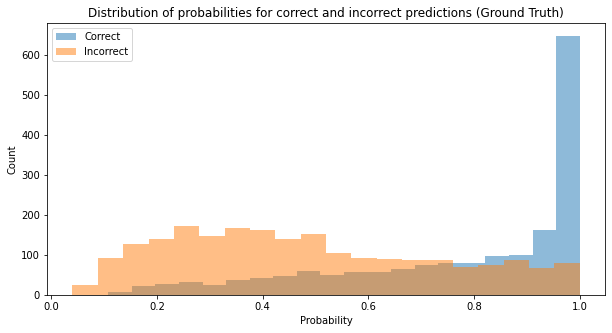

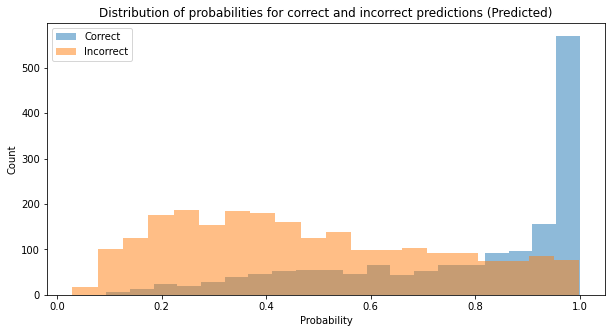

In [15]:
# obtain the top-1 correct and incorrect predictions with their respective probabilities

gt_top1_correct = []
gt_top1_incorrect = []
pred_top1_correct = []
pred_top1_incorrect = []

for i in range(len(gt_predictions)):
    gt_top1_correct.append(np.argmax(gt_predictions[i]) == gt_data.labels[i])
    gt_top1_incorrect.append(np.argmax(gt_predictions[i]) != gt_data.labels[i])
    pred_top1_correct.append(np.argmax(pred_predictions[i]) == pred_data.labels[i])
    pred_top1_incorrect.append(np.argmax(pred_predictions[i]) != pred_data.labels[i])

gt_top1_correct = np.array(gt_top1_correct)
gt_top1_incorrect = np.array(gt_top1_incorrect)
pred_top1_correct = np.array(pred_top1_correct)
pred_top1_incorrect = np.array(pred_top1_incorrect)

gt_top1_correct_prob = np.max(gt_predictions[gt_top1_correct], axis=1)
gt_top1_incorrect_prob = np.max(gt_predictions[gt_top1_incorrect], axis=1)
pred_top1_correct_prob = np.max(pred_predictions[pred_top1_correct], axis=1)
pred_top1_incorrect_prob = np.max(pred_predictions[pred_top1_incorrect], axis=1)

# plot the distribution of probabilities for correct and incorrect predictions

plt.figure(figsize=(10, 5))
plt.hist(gt_top1_correct_prob, bins=20, alpha=0.5, label='Correct')
plt.hist(gt_top1_incorrect_prob, bins=20, alpha=0.5, label='Incorrect')
plt.title('Distribution of probabilities for correct and incorrect predictions (Ground Truth)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(pred_top1_correct_prob, bins=20, alpha=0.5, label='Correct')
plt.hist(pred_top1_incorrect_prob, bins=20, alpha=0.5, label='Incorrect')
plt.title('Distribution of probabilities for correct and incorrect predictions (Predicted)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

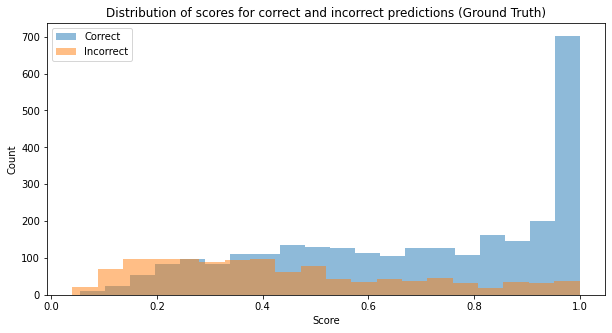

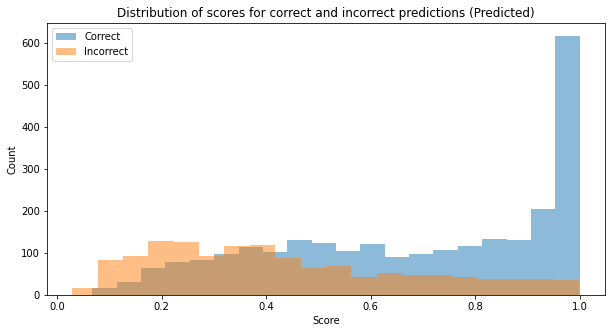

In [16]:
# obtain the top-5 correct and incorrect predictions with their respective scores

gt_top5_correct = []
gt_top5_incorrect = []
pred_top5_correct = []
pred_top5_incorrect = []

for i in range(len(gt_predictions)):
    gt_top5_correct.append(gt_data.labels[i] in np.argsort(gt_predictions[i])[-5:])
    gt_top5_incorrect.append(gt_data.labels[i] not in np.argsort(gt_predictions[i])[-5:])
    pred_top5_correct.append(pred_data.labels[i] in np.argsort(pred_predictions[i])[-5:])
    pred_top5_incorrect.append(pred_data.labels[i] not in np.argsort(pred_predictions[i])[-5:])

gt_top5_correct = np.array(gt_top5_correct)
gt_top5_incorrect = np.array(gt_top5_incorrect)
pred_top5_correct = np.array(pred_top5_correct)
pred_top5_incorrect = np.array(pred_top5_incorrect)

gt_top5_correct_score = np.max(gt_predictions[gt_top5_correct], axis=1)
gt_top5_incorrect_score = np.max(gt_predictions[gt_top5_incorrect], axis=1)
pred_top5_correct_score = np.max(pred_predictions[pred_top5_correct], axis=1)
pred_top5_incorrect_score = np.max(pred_predictions[pred_top5_incorrect], axis=1)

# plot the distribution of scores for correct and incorrect predictions

plt.figure(figsize=(10, 5))
plt.hist(gt_top5_correct_score, bins=20, alpha=0.5, label='Correct')
plt.hist(gt_top5_incorrect_score, bins=20, alpha=0.5, label='Incorrect')
plt.title('Distribution of scores for correct and incorrect predictions (Ground Truth)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(pred_top5_correct_score, bins=20, alpha=0.5, label='Correct')
plt.hist(pred_top5_incorrect_score, bins=20, alpha=0.5, label='Incorrect')
plt.title('Distribution of scores for correct and incorrect predictions (Predicted)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.show()


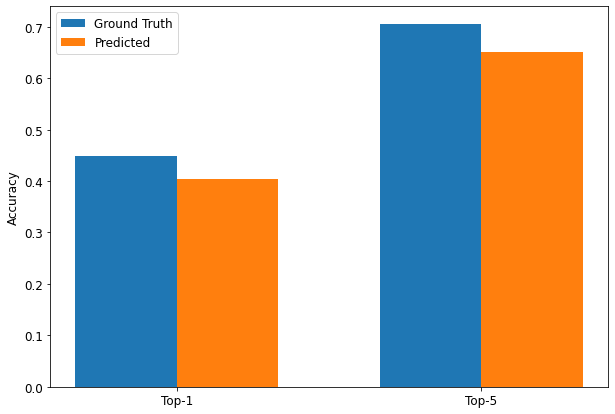

In [32]:
# accuracy of top-1 and top-5 cases

gt_top1_correct_acc = np.mean(gt_top1_correct)
pred_top1_correct_acc = np.mean(pred_top1_correct)
gt_top5_correct_acc = np.mean(gt_top5_correct)
pred_top5_correct_acc = np.mean(pred_top5_correct)

# plot the accuracy of cases in a grouped bar chart

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 7))
plt.bar([0, 0.9], [gt_top1_correct_acc, gt_top5_correct_acc], width=0.3, label='Ground Truth')
plt.bar([0.3, 1.2], [pred_top1_correct_acc, pred_top5_correct_acc], width=0.3, label='Predicted')
plt.ylabel('Accuracy')
plt.xticks([0.15, 1.05], ['Top-1', 'Top-5'])
plt.legend()
plt.show()

## Scratch

Code used for testing and operations

In [ ]:
# Image Folder Manipulation

src_dir = '../Datasets/mini_imagenet/imagenet-mini/train'
dst_dir = '../Datasets/mini_imagenet/imagenet-mini/train_subset'
existing_dir = '../Datasets/mini_imagenet/imagenet-mini/test_images_gt'

for root, dirs, files in os.walk(existing_dir):
    for file in files:
        if file.endswith(".JPEG"):
            # copy from src_dir to dst_dir
            src = os.path.join(src_dir, root.split('/')[-1], file)
            dst = os.path.join(dst_dir, root.split('/')[-1], file)
            if not os.path.exists(os.path.join(dst_dir, root.split('/')[-1])):
                os.makedirs(os.path.join(dst_dir, root.split('/')[-1]))
            shutil.copyfile(src, dst)